# <span style="color:lightblue"><center><b>CLASSIFICAÇÃO DOS ESTÁGIOS DA CIRROSE</b></center></span>

Neste notebook vamos realizar  um processo de classificação de Estágio da cirrose utilizando o dataset que fizemos na análise exploratória anterior ([Liver Cirrhosis Stage Classification](https://www.kaggle.com/datasets/aadarshvelu/liver-cirrhosis-stage-classification)), com a intenção de explorar e classificar a coluna **"Estágio"**, que indica qual o estágio atual da cirrose do paciente. 

Com isso, faremos a criação de modelos de Regressão Linear, Árvore de Decisão, Redes Neurais e LGBM (Modelo Ensemble) para identificar o estágio atual da cirrose de um determinado paciente, com base nos dados de input, visando a melhor acurácia possível nos modelos.

Para isso, dividimos o nosso proceder em duas seções:

**1. Importação, Transformação e Exploração**
* Aqui realizamos a importação das bibliotecas que iremos utilizar neste notebook, tratamos alguns dados e exploramos algumas correlações.

**2. Desenvolvendo Modelos**
* Já aqui, temos o desenvolvimento dos modelos de fato. Separamos em algumas subseções, uma para cada modelo que foi implementado, que no caso foram:
    * Regressão Logística
    * Árvore de Decisão
    * Rede Neural
    * LGBM

**3. Comparando os Resultados dos Modelos**
* Por fim, iremos comparar a performance de cada modelo nos testes realizados, utilizando a acurácia como parâmetros para decidir qual foi o melhor.


---
# **Seção 1: Importação, Transformação e Exploração**
---

### **Importando as Bibliotecas**


In [1]:
# Manipulação e Visualização de Dados
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib.colors import LinearSegmentedColormap 
from seaborn import heatmap
from sklearn.preprocessing import LabelEncoder
# Avisos
import warnings
# Normalizador de Dados
from sklearn.preprocessing import StandardScaler 
# Resultados de modelos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Modelos de Regressão 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Modelo de Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
# Modelo de Redes Neurais
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# Ensemble
import lightgbm as lgb
# Salvar e usar modelos
from joblib import load
from joblib import dump

In [2]:
warnings.filterwarnings('ignore') # Remoção de avisos apenas para fins estéticos do Notebook

### **Importando os Dados**


* Para treinar os modelos, importaremos o arquivo csv "liver_cirrhosis_v2", que foi o arquivo previamente separado na etapa de limpeza de dados, removendo boa parte das variáveis do Dataframe e deixando apenas as mais importantes para a classificação dos estágios da cirrose.

In [3]:
# Lendo o arquivo CSV
df = pd.read_csv('../data/dados_processados/liver_cirrhosis_v2.csv')

# Inicializando o LabelEncoder
label_encoder = LabelEncoder()

# Ajustando e transformando a coluna 'Estágio'
df['Estágio'] = label_encoder.fit_transform(df['Estágio'])

# Verificando as classes do LabelEncoder
print("Classes do LabelEncoder:", label_encoder.classes_)

df.head()

Classes do LabelEncoder: [1 2 3]


,Idade,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,18499,F,N,S,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,19724,M,S,N,S,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,21699,F,N,S,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


* Agora vamos exibir apenas os dados categóricos do Dataframe importado, ignorando a coluna "Estágio", que é o nosso alvo.

In [4]:
categoric_columns = list(df.select_dtypes(include=['object']).columns)

df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,F,N,S,N,N
1,M,S,N,S,N
2,F,N,N,N,N
3,F,N,N,N,N
4,F,N,S,N,N


### **Transformando os Dados de Categóricos para Numéricos**

* Sabemos que modelos de Machine Learning não se dão bem com dados categóricos em formato de string, que é o caso do nosso dataset. Por isso vamos codificar valores dessas colunas em números inteiros, transformando as classes de strings para int. Isso permitirá usarmos os dados no modelos de regressão logística;

* Após essa transformação, iremos substituir esses valores no dataframe.

In [5]:
df[categoric_columns] = df[categoric_columns].apply(
                            lambda x: np.where((x == 'S') | (x == 'M'), 1, 0)
                        )
df[categoric_columns].head()

,Sexo,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,1,0,0
1,1,1,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,1,0,0


* Como na coluna "Sexo" o valor M (Masculino) tornou-se 1, iremos mudar o nome da coluna 'Sexo' para 'Sexo Masculino', onde 1 indicará o Sexo Masculino, e 0 indicará o Sexo Feminino;

* Faremos isso pois, apenas recebendo o nome de coluna "Sexo", tendo valores binários de 0 e 1, fica confuso saber se o 0 e o 1 refere-se ao sexo masculino ou feminino. Realizando a mudança, temos a certeza de que sempre irá se referir ao sexo masculino.

In [6]:
df.rename(
    columns={'Sexo':'Sexo Masculino'}, # Mudando 'Sexo' para 'Sexo Masculino', 
    inplace=True # Realiza a mudança no prórprio df
)

# Atualizando a lista de colunas categóricas
categoric_columns.remove('Sexo')
categoric_columns.insert(0,'Sexo Masculino')

df[categoric_columns].head()

,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema
0,0,0,1,0,0
1,1,1,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,1,0,0


### **Transformando a Idade de Dias para Anos**


* Isso é pra uma questão mais prática, pois lidar com idade em anos é muito mais usual do que em dias. Além disso, percebermos uma certa clareza no heatmap quando estávamos comparando com a idade em dias.

In [7]:
df['Idade'] = (df['Idade']/365).astype(int)
df.head()

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
0,50,0,0,1,0,0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,0
1,54,1,1,0,1,0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,1
2,32,0,0,0,0,0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,1
3,45,0,0,0,0,0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,1
4,59,0,0,1,0,0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,0


### **Plotando o Mapa de Calor para Analisarmos as Correlações**



* Antes de prosseguir para qualquer desenvolvimento de qualquer modelo, iremos analisar as correlações das variáveis numéricas com os dados previamente separados por meio dos mapas de calor;

* Como mapas de calor usam matrizes de correlação e uma matriz de correlação é simétrica em torno do diagonal, usaremos uma máscara booleana para visualizar apenas a metade superior de uma matriz de correlação, evitando redundância.

In [8]:
# Gerar uma máscara para a metade superior e criar um mapa triangular
half_mask = np.triu(np.ones_like(df.corr(), dtype=bool))

<Axes: >

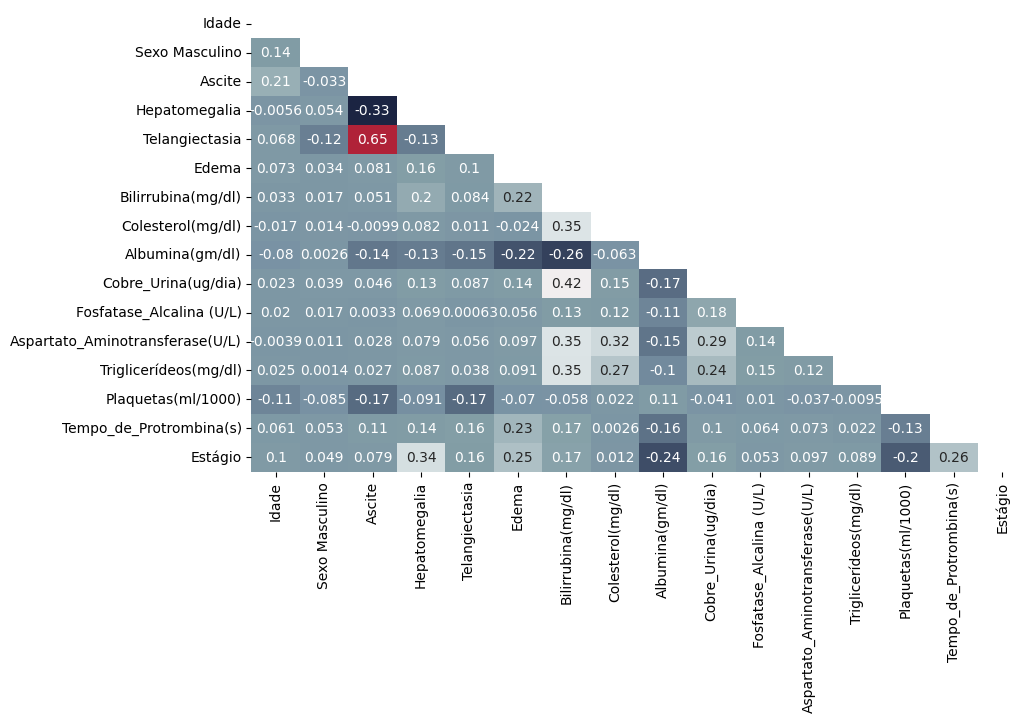

In [9]:
# Mapa de calor com as correlações
colors = ["#1b2442","#7992a4","#829da5","#f4f7f7","#b02238"]
cmap = LinearSegmentedColormap.from_list("custom_palette", colors, N=256)
plt.figure(figsize=[10,6])
heatmap(df.corr(),
        mask=half_mask, 
        annot=True, # Escreve os valores dos coeficientes
        cmap=cmap, # Paleta de cores
        cbar=False,
)

* Uma análise de correlação com heatmap é importante porque permite identificar padrões de relação entre variáveis, ajudando a entender quais características estão mais associadas umas às outras, o que pode orientar na seleção de variáveis para modelos preditivos e na compreensão da estrutura dos dados.

### **Filtrando os Índices de Correlação que Possui Módulo > 0.10**

In [10]:
mask = df.corr().abs() >+ 0.1
filtered = df.corr().where(mask)
filtered

,Idade,Sexo Masculino,Ascite,Hepatomegalia,Telangiectasia,Edema,Bilirrubina(mg/dl),Colesterol(mg/dl),Albumina(gm/dl),Cobre_Urina(ug/dia),Fosfatase_Alcalina (U/L),Aspartato_Aminotransferase(U/L),Triglicerídeos(mg/dl),Plaquetas(ml/1000),Tempo_de_Protrombina(s),Estágio
Idade,1.000000,0.138954,0.205923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112695,NaN,NaN
Sexo Masculino,0.138954,1.000000,NaN,NaN,-0.124024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ascite,0.205923,NaN,1.000000,-0.329621,0.649646,NaN,NaN,NaN,-0.143593,NaN,NaN,NaN,NaN,-0.169384,0.114120,NaN
Hepatomegalia,NaN,NaN,-0.329621,1.000000,-0.132154,0.161125,0.196951,NaN,-0.134408,0.125755,NaN,NaN,NaN,NaN,0.135294,0.336901
Telangiectasia,NaN,-0.124024,0.649646,-0.132154,1.000000,0.100366,NaN,NaN,-0.146398,NaN,NaN,NaN,NaN,-0.171288,0.163029,0.155757
Edema,NaN,NaN,NaN,0.161125,0.100366,1.000000,0.224647,NaN,-0.224724,0.139269,NaN,NaN,NaN,NaN,0.225660,0.254994
Bilirrubina(mg/dl),NaN,NaN,NaN,0.196951,NaN,0.224647,1.000000,0.352127,-0.261299,0.415027,0.132425,0.352460,0.348504,NaN,0.170697,0.172219
Colesterol(mg/dl),NaN,NaN,NaN,NaN,NaN,NaN,0.352127,1.000000,NaN,0.145983,0.117626,0.322665,0.267340,NaN,NaN,NaN
Albumina(gm/dl),NaN,NaN,-0.143593,-0.134408,-0.146398,-0.224724,-0.261299,NaN,1.000000,-0.168683,-0.112587,-0.147348,-0.103031,0.107514,-0.156307,-0.237199
Cobre_Urina(ug/dia),NaN,NaN,NaN,0.125755,NaN,0.139269,0.415027,0.145983,-0.168683,1.000000,0.184010,0.285076,0.239766,NaN,0.101950,0.160070


<Axes: >

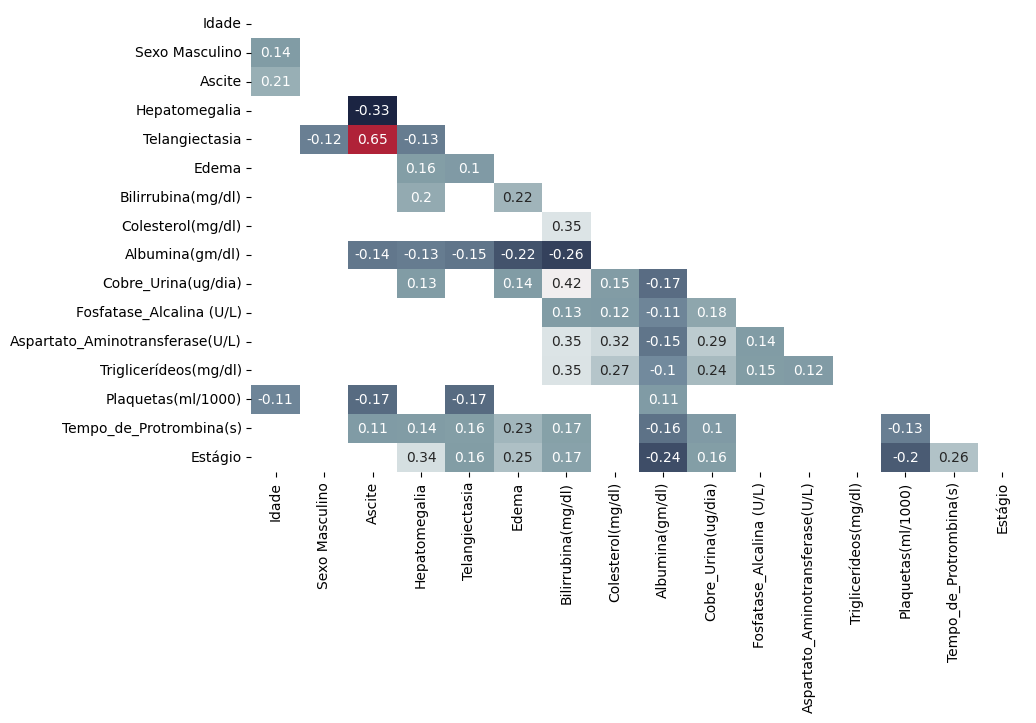

In [11]:
# Mapa de calor com as correlações cujo módulo >= 10
plt.figure(figsize=[10,6])
heatmap(
    filtered,
    mask=half_mask, 
    annot=True, # Escreve os valores dos coeficientes
    cmap=cmap, # Paleta de cores
    cbar=False
)


Perceba que Telangiectasia apresentou uma correlação positiva moderada quase forte com Ascite. Isso pode ser explicado pois: 

'Em geral, pacientes com hepatopatia e ascite apresentam outros estigmas de doença hepática, como presença de telangiectasias[...]'

> Disponível em: [Ascite no paciente cirrótico](https://www.medicinanet.com.br/conteudos/revisoes/5464/ascite_no_paciente_cirrotico.htm)

---
# **Seção 2: Desenvolvendo o Modelos**
---

## **Seção 2.1: Seperando e Normalizando os Dados**



### **Separação de Dados de Treino e Teste**


* Agora que os dados foram devidamente transformados e explorados, vamos separar nossa base de dados em conjuntos de treino e teste. Para isso, utilizamos o método `train_test_split` do scikit-learn;

* A princípio, iremos separar os dados entre as variáveis **preditoras** _(variáveis utilizadas para prever algo: X)_, e a variável **alvo** _(variável a ser prevista: Y)_. Nesse caso, vamos dividir 80% dos dados para treino e 20% para teste;

In [12]:
# Obtendo as variáveis x e y para treinar o modelo 
X = df.drop(columns=['Estágio']).values
Y = df['Estágio'].values

# Dividindo 80% dos dados para treinar o modelo e 20% para os testes
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print("Quantidade total de linhas do DataFrame: " + str(len(df)))
print("Tamanho separado para treinos: " + str(len(X_train)))
print("Tamanho separado para testes: " + str(len(X_test)) + "\n")

print(X)
print(Y)

Quantidade total de linhas do DataFrame: 9637
Tamanho separado para treinos: 7709
Tamanho separado para testes: 1928

[[ 50.    0.    0.  ...  57.  256.    9.9]
 [ 54.    1.    1.  ...  75.  220.   10.8]
 [ 32.    0.    0.  ...  80.  225.   10. ]
 ...
 [ 67.    0.    0.  ...  84.  412.   11.8]
 [ 58.    0.    0.  ...  90.  228.   10.3]
 [ 78.    1.    1.  ...  99.   97.   11.2]]
[0 1 1 ... 2 1 2]


### **Normalizando os Dados**

* Continuando no nosso notebook, nesta etapa iremos realizar a normalização dos dados. A normalização é um passo importante no pré-processamento dos dados para muitos algoritmos de machine learning. O objetivo da normalização é fazer com que dados de diferentes características que podem estar em diferentes escalas tenham uma escala comum;
 
* Isso é importante pois, sem normalização, características com valores maiores podem dominar aquelas com valores menores, afetando negativamente o desempenho do modelo;

* Para isso, utilizamos o objeto `StandardScaler` do scikit-learn para normalizar nossos dados de treino e teste;

* Depois de ser aplicada a normalização, salvamos o scaler na pasta _**"scalers/scaler_estagio"**_ com nome _**"estagio_scaler.joblib"**_, caso queira ser usado em alguma aplicação no futuro.

In [13]:
# Normalizando as variáveis preditoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Salvando o scaler para uso futuro
print("O normalizador 'estagio_scaler' foi salvo em:")
dump(scaler, 'scalers/scalers_estagio/estagio_scaler.joblib')

O normalizador 'estagio_scaler' foi salvo em:


['scalers/scalers_estagio/estagio_scaler.joblib']

## **Seção 2.2: Modelo de Regressão Logística**

* Nosso primeiro modelo de classificação será implementado utilizando a Regressão Logística. Usaremos o objeto **Logistic Regression** e aplicaremos o método *fit()* para treinar nosso modelo. Após o treinamento, as previsões serão armazenadas em uma variável distinta. Os resultados da regressão serão exibidos em uma tabela, mostrando a precisão para cada classe e a acurácia geral, além de uma matriz de confusão para as três classes;

* Finalmente, o modelo de Regressão Logística será salvo na pasta _**"modelos/modelos_estagio"**_, no arquivo nomeado _**"estagio_logreg.joblib"**_, facilitando o acesso futuro caso necessário.

In [14]:
# Instanciando o classificador
reg_classifier = LogisticRegression(max_iter=4000, n_jobs=-1)

# Treinando o modelo
reg_classifier.fit(X_train_scaled, y_train)

# Predict com dados de treino
reg_train_predict = reg_classifier.predict(X_train_scaled)

# Tabela de Resultados
print("Report - Regressão Logística com Dados de Treino:")
print(classification_report(y_train, reg_train_predict))

Report - Regressão Logística com Dados de Treino:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      2416
           1       0.49      0.39      0.43      2639
           2       0.63      0.71      0.67      2654

    accuracy                           0.55      7709
   macro avg       0.54      0.55      0.54      7709
weighted avg       0.54      0.55      0.54      7709



In [15]:
# Realizando as predições do teste
reg_test_predict = reg_classifier.predict(X_test_scaled) # Classe da predição

# Resultados do modelo
print("Report - Regressão Logística com Dados de Teste:")
print(classification_report(y_test, reg_test_predict))

Report - Regressão Logística com Dados de Teste:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       609
           1       0.50      0.37      0.43       669
           2       0.63      0.73      0.68       650

    accuracy                           0.54      1928
   macro avg       0.53      0.54      0.53      1928
weighted avg       0.53      0.54      0.53      1928



* O nosso modelo atingiu apenas ~54% de acurácia. Outros parâmetros foram testados, além da substituição e remoção de outras variáveis, mas devido a complexidade do problema e a configuração dos dados, o modelo de Regressão Logística não é robusto o suficente. 

In [168]:
# Importância das classes para o modelo
coefficients_reg = reg_classifier.coef_
feature_importance_reg = pd.DataFrame(
    coefficients_reg.T, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=[str(col) for col in reg_classifier.classes_]
    ).reset_index()

# Valor calculado em módulo pois o sinal apenas indica o tipo de relação
module_values = feature_importance_reg.iloc[:, 1:].abs()

feature_importance_reg['importancia_regressao'] = module_values.mean(axis=1)
feature_importance_reg = feature_importance_reg.sort_values(
                                ascending=False, 
                                by='importancia_regressao'
                                ).rename(columns={'index':'var'})

print("Importância das Variáveis (Coeficientes):\n")
feature_importance_reg


Importância das Variáveis (Coeficientes):



,var,0,1,2,importancia_regressao
3,Hepatomegalia,-0.464771,-0.041281,0.506052,0.337368
14,Tempo_de_Protrombina(s),-0.098175,-0.205904,0.304079,0.202719
8,Albumina(gm/dl),0.084762,0.179730,-0.264492,0.176328
5,Edema,-0.189829,0.003522,0.186307,0.126553
4,Telangiectasia,-0.189217,0.064828,0.124389,0.126145
13,Plaquetas(ml/1000),0.180203,-0.014918,-0.165285,0.120135
2,Ascite,0.010178,-0.161918,0.151740,0.107945
7,Colesterol(mg/dl),0.017054,0.111335,-0.128390,0.085593
0,Idade,-0.009659,-0.109275,0.118933,0.079289
9,Cobre_Urina(ug/dia),-0.116814,0.030977,0.085837,0.077876


* Interpretar os coeficientes de um modelo de regressão logística é fundamental para entender o impacto que cada variável possui na probabilidade do evento alvo. Por exemplo, um coeficiente positivo indica que quanto maior ele for, maior será a probabilidade do evento acontecer. Caso seja negativo, indica o contrário. Veja uma análise mais completa abaixo:

#### **Análise dos Coeficientes da Regressão Logística**

#### Hepatomegalia
- **Coeficiente (Estágio 0)**: -0.464771
  - A presença de hepatomegalia está associada a uma diminuição significativa na probabilidade de estar no estágio 0 da cirrose.
- **Coeficiente (Estágio 1)**: -0.041281
  - A presença de hepatomegalia está ligeiramente associada a uma diminuição na probabilidade de estar no estágio 1 da cirrose.
- **Coeficiente (Estágio 2)**: 0.506052
  - A presença de hepatomegalia está fortemente associada a um aumento na probabilidade de estar no estágio 2 da cirrose.

#### Albumina (gm/dl)
- **Coeficiente (Estágio 0)**: 0.084762
  - Aumentar os níveis de albumina está ligeiramente associado a um aumento na probabilidade de estar no estágio 0 da cirrose.
- **Coeficiente (Estágio 1)**: 0.179730
  - Aumentar os níveis de albumina está associado a um aumento na probabilidade de estar no estágio 1 da cirrose.
- **Coeficiente (Estágio 2)**: -0.264492
  - Aumentar os níveis de albumina está associado a uma diminuição na probabilidade de estar no estágio 2 da cirrose.

#### Tempo de Protrombina (s)
- **Coeficiente (Estágio 0)**: -0.098175
  - Aumentar o tempo de protrombina está associado a uma diminuição na probabilidade de estar no estágio 0 da cirrose.
- **Coeficiente (Estágio 1)**: -0.205904
  - Aumentar o tempo de protrombina está fortemente associado a uma diminuição na probabilidade de estar no estágio 1 da cirrose.
- **Coeficiente (Estágio 2)**: 0.304079
  - Aumentar o tempo de protrombina está associado a um aumento na probabilidade de estar no estágio 2 da cirrose.

#### Plaquetas (ml/1000)
- **Coeficiente (Estágio 0)**: 0.180203
  - Aumentar a contagem de plaquetas está associado a um aumento na probabilidade de estar no estágio 0 da cirrose.
- **Coeficiente (Estágio 1)**: -0.014918
  - Aumentar a contagem de plaquetas está ligeiramente associado a uma diminuição na probabilidade de estar no estágio 1 da cirrose.
- **Coeficiente (Estágio 2)**: -0.165285
  - Aumentar a contagem de plaquetas está associado a uma diminuição na probabilidade de estar no estágio 2 da cirrose.

#### Ascite
- **Coeficiente (Estágio 0)**: 0.010178
  - A presença de ascite está ligeiramente associada a um aumento na probabilidade de estar no estágio 0 da cirrose.
- **Coeficiente (Estágio 1)**: -0.161918
  - A presença de ascite está associada a uma diminuição na probabilidade de estar no estágio 1 da cirrose.
- **Coeficiente (Estágio 2)**: 0.151740
  - A presença de ascite está associada a um aumento na probabilidade de estar no estágio 2 da cirrose.

### **Exibindo a Matriz de Confusão da Regressão Logística**

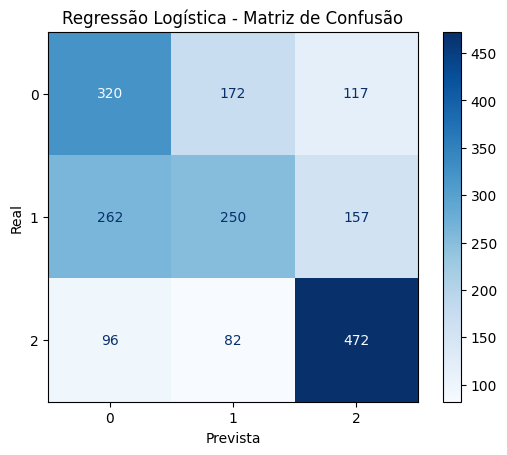

In [17]:
# Matriz de confusão
cm = confusion_matrix(y_test, reg_test_predict)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=reg_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title('Regressão Logística - Matriz de Confusão')
plt.xlabel('Prevista')
plt.ylabel('Real')

plt.show()

#### **Análise da Matriz de Confusão de Regresão Logística**

#### Classe 0
- **Predições corretas (0,0)**: 320
  - O modelo previu corretamente a classe 0 em 320 casos.
- **Falsos positivos (0,1)**: 172
  - O modelo previu incorretamente a classe 1 quando era realmente a classe 0 em 172 casos.
- **Falsos positivos (0,2)**: 117
  - O modelo previu incorretamente a classe 2 quando era realmente a classe 0 em 117 casos.

#### Classe 1
- **Predições corretas (1,1)**: 250
  - O modelo previu corretamente a classe 1 em 250 casos.
- **Falsos negativos (1,0)**: 262
  - O modelo previu incorretamente a classe 0 quando era realmente a classe 1 em 262 casos.
- **Falsos positivos (1,2)**: 157
  - O modelo previu incorretamente a classe 2 quando era realmente a classe 1 em 157 casos.

#### Classe 2
- **Predições corretas (2,2)**: 472
  - O modelo previu corretamente a classe 2 em 472 casos.
- **Falsos negativos (2,0)**: 96
  - O modelo previu incorretamente a classe 0 quando era realmente a classe 2 em 96 casos.
- **Falsos negativos (2,1)**: 82
  - O modelo previu incorretamente a classe 1 quando era realmente a classe 2 em 82 casos.


### **Salvando Modelo de Regressão Linear**

In [18]:
# Salvando o modelo para uso futuro
print("O modelo do scaler foi salvo em:")
dump(reg_classifier, 'models/modelos_estagio/estagio_logreg.joblib')

O modelo do scaler foi salvo em:


['models/modelos_estagio/estagio_logreg.joblib']

## **Seção 2.3: Modelo de Árvore de Decisão**


* Agora vamos explorar outra abordagem de classificação. Desta vez, utilizaremos o modelo 'Árvore de Decisão', que pode ser útil para visualizar melhor o processo de classificação e potencialmente oferecer resultados superiores em termos de acurácia e precisão. Observe que podemos reutilizar as mesmas variáveis X e Y, pois elas não foram modificadas.

* Após isso, o modelo de Árvore de Decisão será salvo na pasta _**"modelos/modelos_estagio"**_, no arquivo nomeado _**"estagio_dectree.joblib"**_, facilitando o acesso futuro caso necessário.

In [19]:
# Instanciando Árvore de Decisão
arvore = DecisionTreeClassifier(
    random_state=42, 
    min_impurity_decrease=9.1e-05
)

# Treinando o modelo
arvore.fit(X_train, y_train)

# Predict com dados de treino
arvore_train_predict = arvore.predict(X_train)

# Tabela de Resultados - Dados de Treino
print("Report - Árvore de Decisão com Dados de Treino:")
print(classification_report(y_train, arvore_train_predict))

Report - Árvore de Decisão com Dados de Treino:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2416
           1       0.97      0.97      0.97      2639
           2       0.98      0.98      0.98      2654

    accuracy                           0.97      7709
   macro avg       0.97      0.97      0.97      7709
weighted avg       0.97      0.97      0.97      7709



In [20]:
# Realizando as predições do teste
arvore_test_predict = arvore.predict(X_test)

# Resultados do modelo - Dados de Teste
print("Report - Árvore de Decisão com Dados de Teste:")
print(classification_report(y_test, arvore_test_predict))

Report - Árvore de Decisão com Dados de Teste:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       609
           1       0.76      0.72      0.74       669
           2       0.82      0.84      0.83       650

    accuracy                           0.78      1928
   macro avg       0.78      0.78      0.78      1928
weighted avg       0.78      0.78      0.78      1928



* Perceba que nos dados de treino da nossa árvore de decisão, a acurácia foi de ~97%, enquanto que nos dados de teste a acurácia foi de ~78%. Isso indica que nosso modelo está com _Overfitting_, o que nos leva querer buscar soluções para adequar esse modelo.

* Para evitar isso, vamos realizar uma técnica chamada Grid Search para encontrar o melhor valor para o **ccp_alpha**, um parâmetro que nos ajuda a regularizar a árvore e evitar _overfitting_.

### **Realizando o Grid Search**


In [21]:
# Instanciando nova árvore
arvore_teste = DecisionTreeClassifier()

# Criando o caminho da poda de complexidade de custo
path = arvore_teste.cost_complexity_pruning_path(X_train_scaled, y_train)

# Realizando o Grid Search
param_grid = {'ccp_alpha': path.ccp_alphas}

CV_clf = GridSearchCV(
    estimator=arvore, 
    param_grid=param_grid, 
    cv=7, 
    verbose=2, 
    n_jobs=-1
)

CV_clf.fit(X_train, y_train)

# Atribuindo o ccp_alpha
ccp_alpha = CV_clf.best_estimator_.ccp_alpha

# Instanciando uma nova árvore com o ccp_alpha
arvore_2 = DecisionTreeClassifier(
    random_state=42, 
    ccp_alpha=ccp_alpha,
    min_impurity_decrease=9.1e-05,
)

# Ajustando o modelo DecisionTreeClassifier com os dados de treino
arvore_2.fit(X_train, y_train)

# Realizando as novas predições nos dados de treino
arvore_2_predict_train = arvore_2.predict(X_train)

# Resultados dos dados de treino
print("Report - Árvore de Decisão com Dados de Treino após Grid Search:")
print(classification_report(y_train, arvore_2_predict_train))

Fitting 7 folds for each of 931 candidates, totalling 6517 fits
Report - Árvore de Decisão com Dados de Treino após Grid Search:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2416
           1       0.88      0.90      0.89      2639
           2       0.93      0.93      0.93      2654

    accuracy                           0.90      7709
   macro avg       0.90      0.90      0.90      7709
weighted avg       0.90      0.90      0.90      7709



In [22]:
# Realizando as novas predições nos dados de teste
arvore_2_predict_test = arvore_2.predict(X_test)

# Resultados do novo modelo
print("Report - Árvore de Decisão com Dados de Teste após Grid Search:")
print(classification_report(y_test, arvore_2_predict_test))

Report - Árvore de Decisão com Dados de Teste após Grid Search:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       609
           1       0.75      0.73      0.74       669
           2       0.83      0.82      0.82       650

    accuracy                           0.78      1928
   macro avg       0.78      0.78      0.78      1928
weighted avg       0.78      0.78      0.78      1928



* Observe as novas escalas das nossas acurácias:
    - Antes do GridSearch: 
        - 97% nos dados de treino 
        - 78% nos dados de teste 
    - Depois do GridSearch: 
        - 90% nos dados de treino 
        - 78% nos dados de teste 

* Perceba que a acurácia com os dados de treino caiu para 89%, porém a acurácia com os dados de teste permaneceu a mesma. Isso indica que o nosso modelo reduziu o fator de _overfitting_ sem prejudicar a acurácia com dados de teste, e com isso, vemos que o ccp_alpha realmente nos ajudou.

### **Exibindo a Árvore de Decisão**

* Vamos plotar a nossa árvore de decisão, para que possamos visualizar as etapas que o modelo tomou e nós que realizou para alcançar tais resultados.

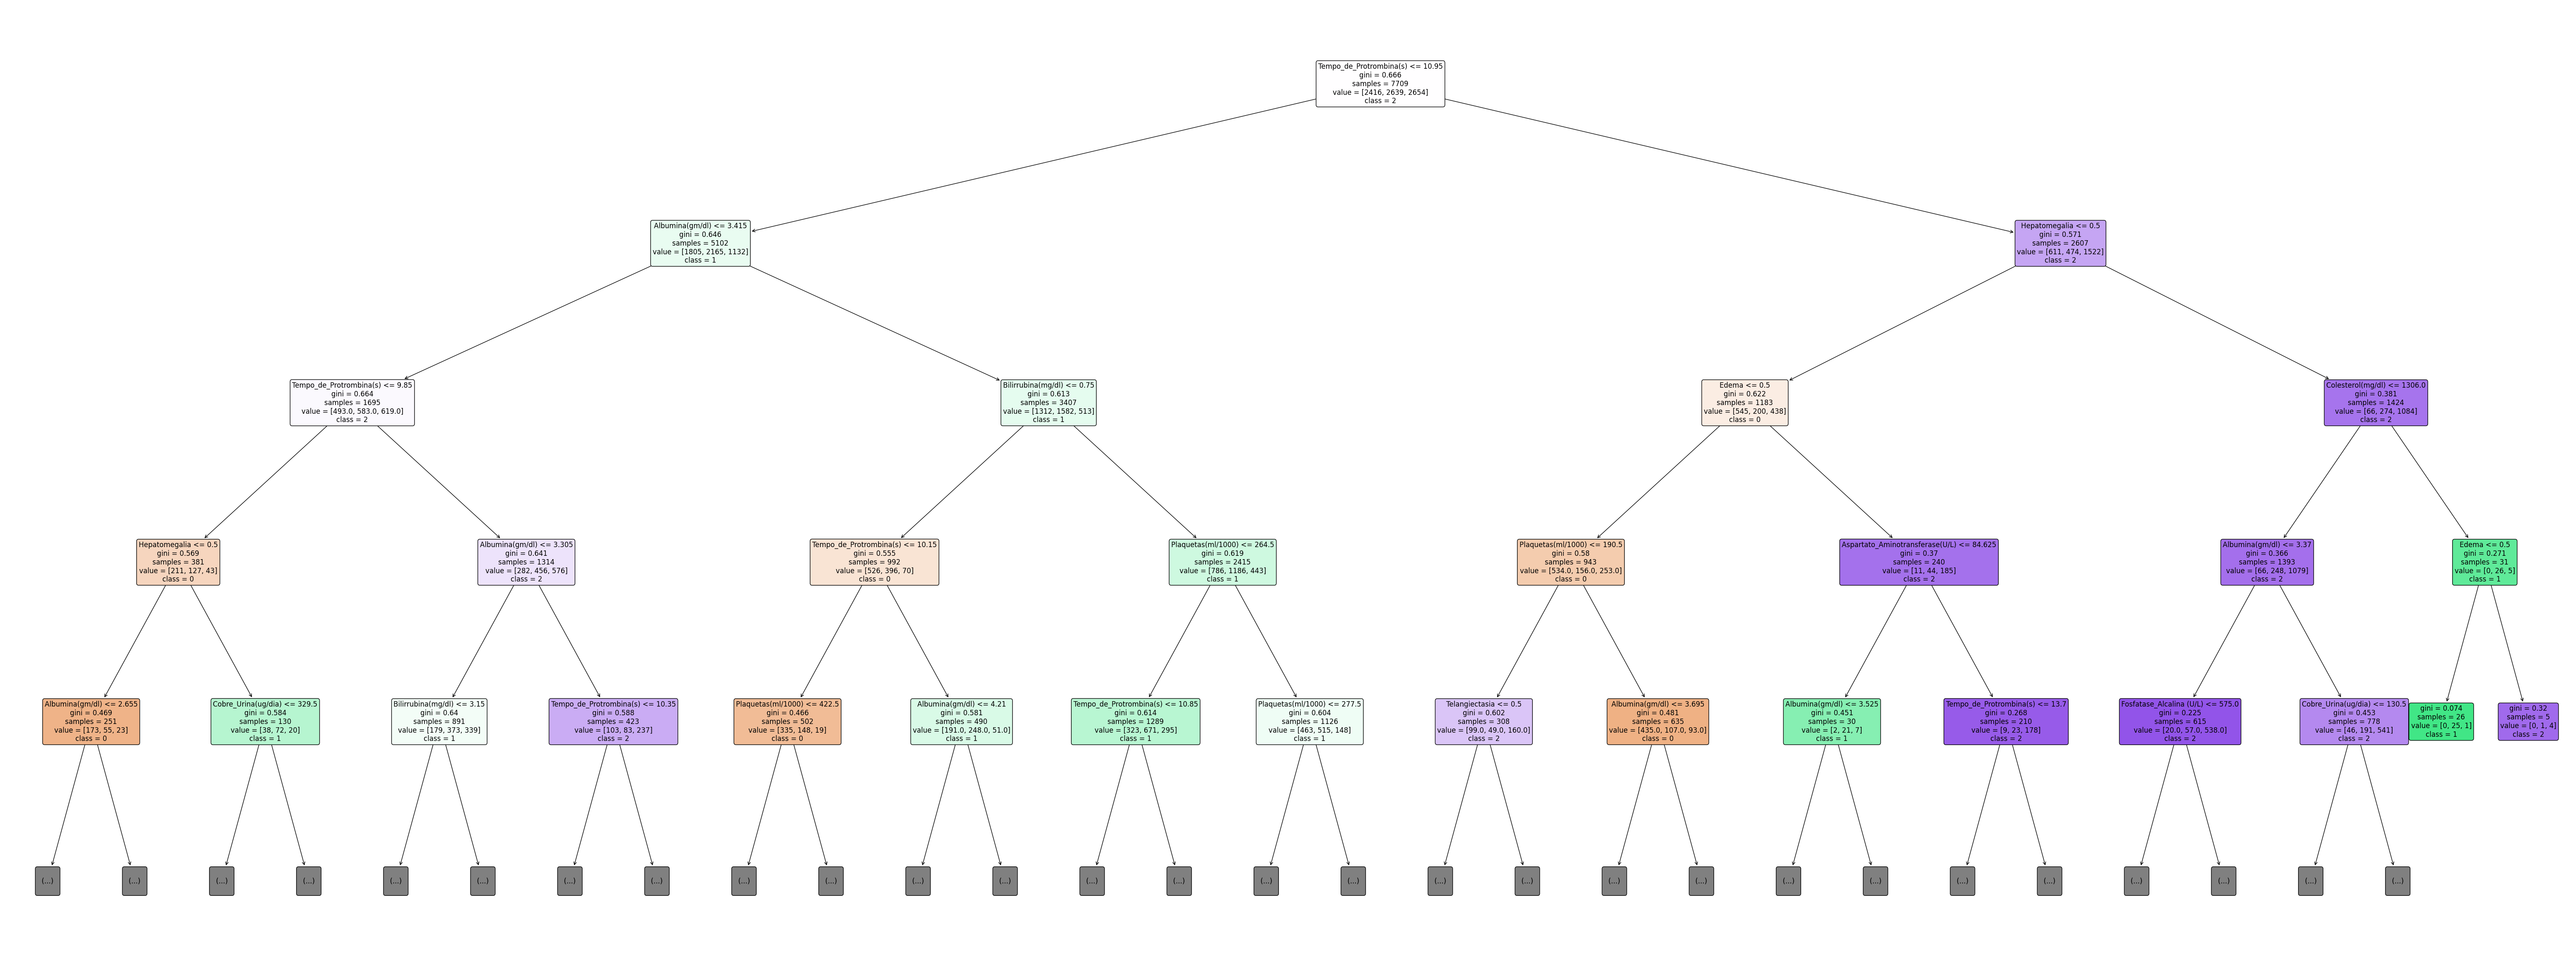

In [23]:
# Plotando a árvore
plt.figure(figsize=(80,30))
plot_tree(
    arvore_2, 
    feature_names=df.drop(columns=['Estágio']).columns, 
    class_names=[str(cls) for cls in arvore_2.classes_], 
    filled=True, 
    rounded=True, 
    fontsize=12,
    max_depth=4
    )
plt.show()

### **Importância das Features na Árvore de Decisão**

In [167]:
# Obter a importância das variáveis
importances = arvore_2.feature_importances_
feature_importance_tree = pd.DataFrame(
    importances, 
    index=df.drop('Estágio', axis=1).columns, 
    columns=['importance_tree']
    ).sort_values(by='importance_tree', ascending=False)

thresholds = np.percentile(importances,[33.33, 66.67])

# Categorizando a importância das variáveis
feature_importance_tree = feature_importance_tree.assign(
    relation = lambda x: np.where(
                            x.importance_tree > thresholds[1], 'Forte',
                            np.where(
                                x.importance_tree > thresholds[0], 'Moderada', 'Fraca'
                            )
                        )
).reset_index().rename(columns={'index':'var'})

print("Importância das Variáveis:\n")
display(feature_importance_tree)

Importância das Variáveis:



,var,importance_tree,relation
0,Tempo_de_Protrombina(s),0.200940,Forte
1,Albumina(gm/dl),0.172321,Forte
2,Plaquetas(ml/1000),0.147207,Forte
3,Hepatomegalia,0.083191,Forte
4,Idade,0.079235,Forte
5,Bilirrubina(mg/dl),0.066488,Moderada
6,Aspartato_Aminotransferase(U/L),0.048276,Moderada
7,Cobre_Urina(ug/dia),0.045165,Moderada
8,Fosfatase_Alcalina (U/L),0.036060,Moderada
9,Edema,0.034572,Moderada


#### **Interpretação das Importâncias das Features:**

1. **Tempo de Protrombina (s)**: Importância = 0.200940
   - O tempo de protrombina é a variável mais importante na classificação. Com uma importância de aproximadamente 0.20, ela é a variável que mais contribui para a separação dos dados no modelo. Esta variável demonstra uma forte relação com a variável alvo, indicando sua relevância significativa na predição dos resultados.

2. **Albumina (gm/dl)**: Importância = 0.172321
   - A albumina também possui uma importância considerável, com uma contribuição de aproximadamente 0.17. Embora menos significativa que o tempo de protrombina, a albumina ainda tem um papel crucial na classificação, sendo uma variável relevante para o modelo.

3. **Plaquetas (ml/1000)**: Importância = 0.147207
   - As plaquetas apresentam uma importância de cerca de 0.15, evidenciando que elas também são uma variável importante no modelo. Sua contribuição é significativa na separação dos dados, desempenhando um papel relevante na classificação.

4. **Hepatomegalia**: Importância = 0.083191
   - A hepatomegalia tem uma importância de aproximadamente 0.08. Apesar de sua importância ser menor em comparação com as variáveis anteriores, ela ainda contribui de forma relevante para o modelo, ajudando na classificação dos dados.

5. **Idade**: Importância = 0.079235
   - A idade, com uma importância de cerca de 0.08, é a variável menos significativa entre as listadas. No entanto, sua contribuição não é desprezível, indicando que a idade também desempenha um papel na separação dos dados e na predição do modelo.

### **Exibindo a Matriz de Confusão da Árvore de Decisão**

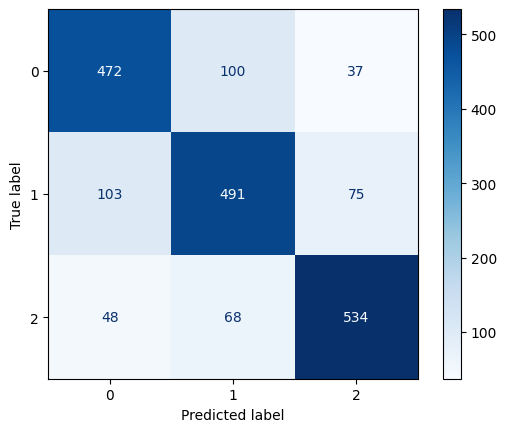

In [25]:
# Matriz de confusão
cm_tree = confusion_matrix(y_test, arvore_2_predict_test)

# Visualizar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree,display_labels=arvore_2.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### **Análise da Matriz de Confusão da Árvore de Decisão**

#### Classe 0
- **Predições corretas (0,0)**: 472
  - O modelo previu corretamente a classe 0 em 472 casos.
- **Falsos positivos (0,1)**: 100
  - O modelo previu incorretamente a classe 1 quando era realmente a classe 0 em 100 casos.
- **Falsos positivos (0,2)**: 37
  - O modelo previu incorretamente a classe 2 quando era realmente a classe 0 em 37 casos.

#### Classe 1
- **Predições corretas (1,1)**: 491
  - O modelo previu corretamente a classe 1 em 491 casos.
- **Falsos negativos (1,0)**: 103
  - O modelo previu incorretamente a classe 0 quando era realmente a classe 1 em 103 casos.
- **Falsos positivos (1,2)**: 75
  - O modelo previu incorretamente a classe 2 quando era realmente a classe 1 em 75 casos.

#### Classe 2
- **Predições corretas (2,2)**: 534
  - O modelo previu corretamente a classe 2 em 534 casos.
- **Falsos negativos (2,0)**: 48
  - O modelo previu incorretamente a classe 0 quando era realmente a classe 2 em 48 casos.
- **Falsos negativos (2,1)**: 68
  - O modelo previu incorretamente a classe 1 quando era realmente a classe 2 em 68 casos.

### **Salvando Modelo da Árvore de Decisão**

In [26]:
print("O modelo de Árvore de Decisão foi salvo em:")
dump(arvore_2, 'models/modelos_estagio/estagio_dectree.joblib')

O modelo de Árvore de Decisão foi salvo em:


['models/modelos_estagio/estagio_dectree.joblib']

### **Extração de Regras de Decisão da Árvore de Decisão**

* Usaremos uma função que percorre a árvore de decisão, analisa o caminho seguido para chegar à predição de uma amostra específica e imprime as regras de decisão associadas a esse caminho. Será útil para entender como a árvore de decisão tomou uma decisão específica para a nossa amostra. 

In [27]:
tree_clf = load('models/modelos_estagio/estagio_dectree.joblib')

In [28]:
def extract_rules(sample_id, clf):
    x_sample = X_test[sample_id]
    y_sample = y_test[sample_id]  # Obtém o label real da classe para a amostra

    # Restante do código permanece o mesmo
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    node_indices = clf.decision_path([x_sample]).indices 
    leaf_id = node_indices[-1]
   
    print('\nFeatures usadas para predizer a amostra %s' % (sample_id))

    for f, v in zip(df.drop(columns=['Estágio']).columns, x_sample):
        print('%s = %s'%(f,v))
    print('\n')      

    for node_id in node_indices:
        if leaf_id == node_id:
            break

        if (x_sample[feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("id do nó de decisão %s : (atributo %s com valor = %s %s %s)"
              % (node_id,
                 df.drop(columns=['Estágio']).columns[feature[node_id]],
                 x_sample[feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))
        
    pred = clf.predict([x_sample])

    print("\tLabel real da classe => %s" % y_sample)  # Imprime o label real da classe
    print("\tClasse prevista => %s" % pred)


extract_rules(10, tree_clf)


Features usadas para predizer a amostra 10
Idade = 61.0
Sexo Masculino = 0.0
Ascite = 0.0
Hepatomegalia = 1.0
Telangiectasia = 0.0
Edema = 0.0
Bilirrubina(mg/dl) = 0.8
Colesterol(mg/dl) = 369.5105634
Albumina(gm/dl) = 3.82
Cobre_Urina(ug/dia) = 58.0
Fosfatase_Alcalina (U/L) = 1236.0
Aspartato_Aminotransferase(U/L) = 97.65
Triglicerídeos(mg/dl) = 124.7021277
Plaquetas(ml/1000) = 233.0
Tempo_de_Protrombina(s) = 11.0


id do nó de decisão 0 : (atributo Tempo_de_Protrombina(s) com valor = 11.0 > 10.949999809265137)
id do nó de decisão 780 : (atributo Hepatomegalia com valor = 1.0 > 0.5)
id do nó de decisão 912 : (atributo Colesterol(mg/dl) com valor = 369.5105634 <= 1306.0)
id do nó de decisão 913 : (atributo Albumina(gm/dl) com valor = 3.82 > 3.3700000047683716)
id do nó de decisão 961 : (atributo Cobre_Urina(ug/dia) com valor = 58.0 <= 130.5)
id do nó de decisão 962 : (atributo Albumina(gm/dl) com valor = 3.82 <= 3.9700000286102295)
id do nó de decisão 963 : (atributo Idade com valor = 

* *Note que o Label real da Classe bate com a Classe prevista, o que indica que está tudo certo.*

## **Seção 2.3: Modelo de Rede Neural**

* O próximo modelo de classificação a ser explorado será uma Rede Neural. Instanciaremos o modelo e treinaremos a rede neural com diferentes camdas. Os resultados da rede neural serão exibidos em uma tabela, mostrando a precisão para cada classe e a acurácia geral.

* Finalmente, o modelo de Rede Neural será salvo na pasta **_"modelos/modelos_estagio"_**, no arquivo nomeado **_"estagio_neural.joblib"_**, facilitando o acesso futuro caso necessário.

### **Instanciando o Modelo**

* Vamos inicializar uma rede neural com:

    * Camada de entrada com 128 neurônios (Função de ativação Relu)
    * 1 camada com 128 neurônios (Função de ativação Relu)
    * 2 camadas com 64 neurônios (Função de ativação Relu)
    * 1 camada com 32 neurônios (Função de ativação Relu)
    * 1 camada com 16 neurônios (Função de ativação Relu)
    * Camada de saída com 3 neurônios (Função de ativação Softmax)

In [121]:
# Instanciando o modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.28),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.28),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.22),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.22),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.08),
    Dense(3, activation='softmax')
])

In [122]:
# Compilando o modelo
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'],
    )

In [123]:
# Sumarizando o modelo
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,363 (138.14 KB)

 Trainable params: 34,499 (134.76 KB)

 Non-trainable params: 864 (3.38 KB)

### **Treinando o Modelo de Rede Neural**

* Aqui, temos o treinamento do modelo de fato. Vamos rodar 600 épocas de 32 amostras cada, para conseguir fazer um treino relativamente conciso e eficaz.

In [124]:
# Treinando o modelo
history = model.fit(
    X_train_scaled, y_train, 
    epochs=500, 
    batch_size=32, 
    validation_data=(X_test_scaled, y_test)
    )

Epoch 1/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3920 - loss: 1.3230 - val_accuracy: 0.4652 - val_loss: 1.0011
Epoch 2/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4634 - loss: 1.0536 - val_accuracy: 0.5456 - val_loss: 0.9066
Epoch 3/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5081 - loss: 0.9732 - val_accuracy: 0.5602 - val_loss: 0.8826
Epoch 4/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5194 - loss: 0.9575 - val_accuracy: 0.5659 - val_loss: 0.8700
Epoch 5/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5387 - loss: 0.9432 - val_accuracy: 0.5809 - val_loss: 0.8623
Epoch 6/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5470 - loss: 0.9272 - val_accuracy: 0.5934 - val_loss: 0.8548
Epoch 7/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5592 - loss: 0.9100 - val_accuracy: 0.5840 - val_loss: 0.8439
Epoch 8/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5629 - loss: 0.9028 - val_accu

In [126]:
# Obtendo os parâmetros de acurácia durante o treinamento
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

### **Exibindo os Resultados da Rede Neural**

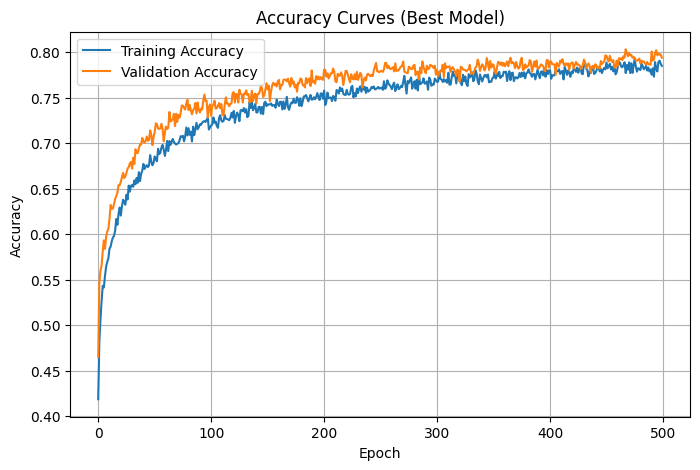

In [127]:
# Plotando a acurácia durante o treinamento
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

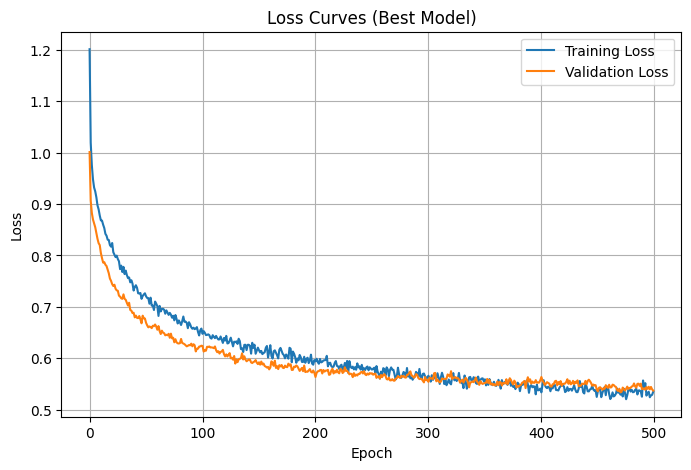

In [128]:
# Plotando o Loss durante o treinamento
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

* O modelo apresentou bons valores de acurácia e loss durante o treinamento, onde os valores de treino e validação se manteram bem próximos, o que indica uma boa constância do modelo e evita _overfittig_.

### **Analisando Possibilidade de Overfitting na Rede Neural**

* Por fim, vamos printar os reports da classificação para analisar os resultados finais do nosso modelo (e checar se está acontecendo overfitting).

#### Resultado com os Dados de Treino

In [129]:
print(classification_report(y_train, np.argmax(model.predict(X_train_scaled), axis=1)))

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2416
           1       0.87      0.88      0.88      2639
           2       0.93      0.93      0.93      2654

    accuracy                           0.90      7709
   macro avg       0.90      0.90      0.90      7709
weighted avg       0.90      0.90      0.90      7709



#### Resultados com os Dados de Teste

In [130]:
print(classification_report(y_test, np.argmax(model.predict(X_test_scaled), axis=1)))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       609
           1       0.76      0.75      0.76       669
           2       0.84      0.85      0.84       650

    accuracy                           0.79      1928
   macro avg       0.79      0.79      0.79      1928
weighted avg       0.79      0.79      0.79      1928



* O modelo obteve 79% de acurácia com os dados de teste. Esse valor é pouco maior do que o obtido com o modelo de Árvore de Decisão, mesmo utilizando Redes Neurais, que é um modelo mais robusto. Os resultados não satisfazem. Isso pode ocorrer devido a complexidade dos dados e pelo fato de que boa parte deles foram gerados de maneira sintética, o que também impede a comparação com casos reais.

### **Salvando Modelo de Rede Neural**

In [134]:
print("O modelo de Rede Neural foi salvo em:")
dump(model, 'models/modelos_estagio/estagio_neural.joblib')

O modelo de Rede Neural foi salvo em:


['models/modelos_estagio/estagio_neural.joblib']

## **Seção 2.4: Modelo de Light Gradient Boosting Machine (LGBM)**

* Para finalizar com nosso último modelo, vamos desenvolver agora a classificação utilizando o modelo Light Gradient Boosting Machine (ou LGBM). Este modelo, ao contrário dos demais, emprega um processo de _Ensemble_ baseado em modelos de **Árvores de Decisão**. O LightGBM funciona construindo múltiplas árvores de decisão em sequência, onde cada árvore tenta corrigir os erros das anteriores, isso desenvolve uma maior robustez e aumenta de maneira significativa a acurácia.

* Finalmente, o modelo de LGBM será salvo na pasta **_"modelos/modelos_estagio"_**, no arquivo nomeado **_"estagio_lgbm.joblib"_**, facilitando o acesso futuro caso necessário.

In [39]:
# Datasets de treino e validação
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label= y_test)

# Definição dos parâmetros do modelo
parameters = {
'objective': 'multiclass',
'boosting_type': 'gbdt',
'metric': 'multi_logloss',
'num_class': len(np.unique(y_test)),
'num_leaves': 15,
'feature_fraction': 0.9,
}

# Treinamento do modelo
model_lgbm = lgb.train(parameters, train_data, valid_sets=[train_data, valid_data], num_boost_round=5000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 7709, number of used features: 15
[LightGBM] [Info] Start training from score -1.160275
[LightGBM] [Info] Start training from score -1.071988
[LightGBM] [Info] Start training from score -1.066321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [40]:
# Realizando as predições 
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_test)

# Obtendo as classes preditas com base na maior probabilidade
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_valid_pred_labels = np.argmax(y_valid_pred, axis=1)

* Depois de treinar o modelo, vamos checar os resultados para tomar conclusões.


In [41]:
# Resultados com os dados de treino
print("Report - Dados de Treino:")
print(classification_report(y_train, y_train_pred_labels, zero_division=0))

Report - Dados de Treino:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2416
           1       0.99      0.99      0.99      2639
           2       1.00      1.00      1.00      2654

    accuracy                           0.99      7709
   macro avg       0.99      0.99      0.99      7709
weighted avg       0.99      0.99      0.99      7709



In [42]:
# Resultados com os dados de Teste
print("Report - LGBM:")
print(classification_report(y_test, y_valid_pred_labels, zero_division=0))

Report - LGBM:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       609
           1       0.89      0.89      0.89       669
           2       0.95      0.94      0.94       650

    accuracy                           0.91      1928
   macro avg       0.91      0.91      0.91      1928
weighted avg       0.91      0.91      0.91      1928



* O modelo apresentou 99x91 de acurácia entre os dados de treino e os dados de teste. Outros parâmetros foram testados para tentar reduzir a acurácia com o treino porém não houveram alterações. Mas independente disso, essa distância entre Treino e Teste não é significativa para indicar overfitting.

### **Exibindo a Matriz de Confusão do Modelo LGBM**

[[550  45  14]
 [ 53 595  21]
 [ 16  25 609]]


<Figure size 600x600 with 0 Axes>

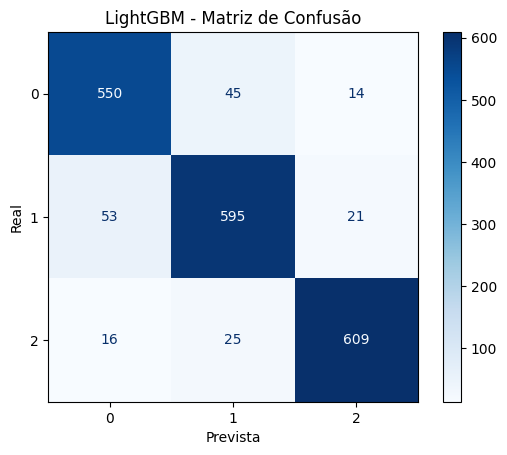

In [43]:
# Matriz de Confusão
matrixLGBMT = confusion_matrix(y_test, y_valid_pred_labels)
print(matrixLGBMT)

plt.figure(figsize=(6, 6))
matrixLGBMPlot1 = ConfusionMatrixDisplay(confusion_matrix=matrixLGBMT, display_labels=np.unique(y_test))
matrixLGBMPlot1.plot(cmap=plt.cm.Blues)

plt.title('LightGBM - Matriz de Confusão')
plt.xlabel('Prevista')
plt.ylabel('Real')

plt.show()

#### **Análise da Matriz de Confusão do Modelo LightGBM**

#### Classe 0
- **Predições corretas (0,0)**: 550
  - O modelo previu corretamente a classe 0 em 550 casos.
- **Falsos positivos (0,1)**: 45
  - O modelo previu incorretamente a classe 1 quando era realmente a classe 0 em 45 casos.
- **Falsos positivos (0,2)**: 14
  - O modelo previu incorretamente a classe 2 quando era realmente a classe 0 em 14 casos.

#### Classe 1
- **Predições corretas (1,1)**: 595
  - O modelo previu corretamente a classe 1 em 595 casos.
- **Falsos negativos (1,0)**: 53
  - O modelo previu incorretamente a classe 0 quando era realmente a classe 1 em 53 casos.
- **Falsos positivos (1,2)**: 21
  - O modelo previu incorretamente a classe 2 quando era realmente a classe 1 em 21 casos.

#### Classe 2
- **Predições corretas (2,2)**: 609
  - O modelo previu corretamente a classe 2 em 609 casos.
- **Falsos negativos (2,0)**: 16
  - O modelo previu incorretamente a classe 0 quando era realmente a classe 2 em 16 casos.
- **Falsos negativos (2,1)**: 25
  - O modelo previu incorretamente a classe 1 quando era realmente a classe 2 em 25 casos.

### **Vendo a Importância dos Coeficientes do Modelo LGBM**

In [166]:
# Obtendo da importância das variáveis
importances = model_lgbm.feature_importance()
feature_names = df.drop(columns=['Estágio']).columns
feature_importance_lgbm = pd.DataFrame({'var': feature_names, 'importance_lgbm': importances})

# Ordenar e calcular os thresholds
feature_importance_lgbm = feature_importance_lgbm.sort_values(by='importance_lgbm', ascending=False)
thresholds = np.percentile(importances, [33.33, 66.67])

# Categorizando a importância das variáveis
feature_importance_lgbm = feature_importance_lgbm.assign(
    Relation=lambda x: np.where(
        x.importance_lgbm > thresholds[1], 'Forte',
        np.where(
            x.importance_lgbm > thresholds[0], 'Moderada', 'Fraca'
        )
    )
)

# Normalizar as importâncias para somar 1
total_importance = feature_importance_lgbm['importance_lgbm'].sum()
feature_importance_lgbm['importance_lgbm'] = feature_importance_lgbm['importance_lgbm'] / total_importance


print("Importância das Variáveis:\n")
display(feature_importance_lgbm)

Importância das Variáveis:



,var,importance_lgbm,Relation
13,Plaquetas(ml/1000),0.201728,Forte
8,Albumina(gm/dl),0.144669,Forte
14,Tempo_de_Protrombina(s),0.118607,Forte
0,Idade,0.117278,Forte
6,Bilirrubina(mg/dl),0.087411,Forte
10,Fosfatase_Alcalina (U/L),0.062754,Moderada
12,Triglicerídeos(mg/dl),0.058468,Moderada
9,Cobre_Urina(ug/dia),0.051172,Moderada
11,Aspartato_Aminotransferase(U/L),0.048620,Moderada
7,Colesterol(mg/dl),0.044420,Moderada


### **Salvando o Modelo LGBM**

In [45]:
# Salvando o modelo
print("O modelo de LightGBM foi salvo em:")
dump(model_lgbm, 'models/modelos_estagio/estagio_lightgbm.joblib')

O modelo de LightGBM foi salvo em:


['models/modelos_estagio/estagio_lightgbm.joblib']

---
# **Seção 3: Comparando os Resultados dos Modelos**
---

## Seção 3.1: Resultados do Modelo de **Regressão Logística**

In [55]:
# Regressão Logística
print('Teste\n')
print(classification_report(y_test, reg_test_predict))

Teste

              precision    recall  f1-score   support

           0       0.47      0.53      0.50       609
           1       0.50      0.37      0.43       669
           2       0.63      0.73      0.68       650

    accuracy                           0.54      1928
   macro avg       0.53      0.54      0.53      1928
weighted avg       0.53      0.54      0.53      1928



---
## Seção 3.2: Resultados do Modelo de **Árvore de Decisão**

In [57]:
# Árvore de Decisão com dados de Teste
print('Teste\n')
print(classification_report(y_test, arvore_2_predict_test))

Teste

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       609
           1       0.75      0.73      0.74       669
           2       0.83      0.82      0.82       650

    accuracy                           0.78      1928
   macro avg       0.78      0.78      0.78      1928
weighted avg       0.78      0.78      0.78      1928



---
## Seção 3.3: Resultados do Modelo de **Redes Neurais**

In [132]:
# Redes Neurais com dados de Teste
print('Teste\n')
print(classification_report(y_test, np.argmax(model.predict(X_test_scaled), axis=1)))

Teste

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       609
           1       0.76      0.75      0.76       669
           2       0.84      0.85      0.84       650

    accuracy                           0.79      1928
   macro avg       0.79      0.79      0.79      1928
weighted avg       0.79      0.79      0.79      1928



---
## Seção 3.4: Resultados do Modelo de **Light Gradient Boosting Machine**

In [61]:
# Light Gradient Boosting Machine com dados de Teste
print('Teste\n')
print(classification_report(y_test, y_valid_pred_labels, zero_division=0))

Teste

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       609
           1       0.89      0.89      0.89       669
           2       0.95      0.94      0.94       650

    accuracy                           0.91      1928
   macro avg       0.91      0.91      0.91      1928
weighted avg       0.91      0.91      0.91      1928



---
### **Conclusões**
* Após as comparações, é possível afirmar que, o modelo que apresentou melhor performance em questão de relação da acurácia Treino x Teste foi o modelo de **Light Gradient Boost Machine (LGBM)**.